In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.composition import OneOf
import glob
import os

In [2]:
# 경로 설정

data_path = '/workspace/#Ub370#Uc774#Ud130/Data'

img_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/img/train/'
img_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/img/val/'

json_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/label/train/'
json_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/label/val/'

segment_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/train/'
segment_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/'


img_path_train_anger = img_path_train + 'anger/'
img_path_val_anger = img_path_val + 'anger/'

img_path_train_happy = img_path_train + 'happy/'
img_path_val_happy = img_path_val + 'happy/'

img_path_train_panic = img_path_train + 'panic/'
img_path_val_panic = img_path_val + 'panic/'

img_path_train_sadness = img_path_train + 'sadness/'
img_path_val_sadness = img_path_val + 'sadness/'

In [3]:
# Boundind Box 좌표 정보가 담긴 csv 파일

df_train_anger = pd.read_csv(json_path_train + 'train_anger_1.csv')
df_val_anger = pd.read_csv (json_path_val + 'val_anger.csv')

df_train_happy = pd.read_csv(json_path_train + 'train_happy_1.csv')
df_val_happy = pd.read_csv (json_path_val + 'val_happy.csv')

df_train_panic = pd.read_csv(json_path_train + 'train_panic_1.csv')
df_val_panic = pd.read_csv (json_path_val + 'val_panic.csv')

df_train_sadness = pd.read_csv(json_path_train + 'train_sadness_1.csv')
df_val_sadness = pd.read_csv (json_path_val + 'val_sadness.csv')


#### 데이터 증강
- Albumentation

    - `A.Resize(640,640)` : 이미지 크기 조정
    - `A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7)` : 이미지 확대, 평행 이동, 기울임
    - `A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5)` : 이미지 평행 이동, 회전
    - `A.ElasticTransform(alpha=1, sigma=50, p=0.3)` : 이미지 왜곡 (옆모습 등)
    - `A.HorizontalFlip(p=0.5)` : 이미지 좌우 반전
    - `A.RandomBrightnessContrast(p=0.2)` : 이미지 밝기/대비 조정

In [4]:
processed_data = []

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/anger/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_anger.csv'
# input_dir = img_path_train_anger
# df = df_train_anger

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/happy/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_happy.csv'
# input_dir = img_path_train_happy
# df = df_train_happy

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/panic/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_panic.csv'
# input_dir = img_path_train_panic
# df = df_train_panic

output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/sadness/'
output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_sadness.csv'
input_dir = img_path_train_sadness
df = df_train_sadness

# 가져온 이미지 파일들 출력
for index, row in df.iterrows():
    # 이미지와 바운딩 박스를 정의 (예: [x_min, y_min, x_max, y_max])
    image = cv2.imread(input_dir + row['filename'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 바운딩 박스 좌표 (예시)
    bboxes = [
        [row['annot_A.boxes.minX'], row['annot_A.boxes.minY'], row['annot_A.boxes.maxX'], row['annot_A.boxes.maxY']],
        [row['annot_B.boxes.minX'], row['annot_B.boxes.minY'], row['annot_B.boxes.maxX'], row['annot_B.boxes.maxY']],
        [row['annot_C.boxes.minX'], row['annot_C.boxes.minY'], row['annot_C.boxes.maxX'], row['annot_C.boxes.maxY']],
        [row['avg_box.minX'], row['avg_box.minY'], row['avg_box.maxX'], row['avg_box.maxY']],
            
    ]  # 각 박스는 [x_min, y_min, x_max, y_max]
    category_ids = [1, 2, 3, 4]  # 각 바운딩 박스에 대응하는 카테고리 ID

    # 변환 파이프라인 정의 (이미지 및 바운딩 박스)
    transform = A.Compose(
        [
            A.Resize(640, 640),  # 크기 조정
            A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7), # 확대, 평행 이동, 기울임
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5), # 평행 이동, 회전
            A.ElasticTransform(alpha=1, sigma=50, p=0.3), # 왜곡(뒤틀림)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기
            A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 조정
        ], 
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_id'])
    )

    # 변환 수행
    augmented = transform(image=image, bboxes=bboxes, category_id=category_ids)

    # 변환된 이미지 및 바운딩 박스
    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']

    # 바운딩 박스 중 가장 큰 영역만 남기기
    # 면적 계산: (x_max - x_min) * (y_max - y_min)
    def get_largest_bbox(bboxes):
        largest_bbox = None
        largest_area = 0
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            area = (x_max - x_min) * (y_max - y_min)
            if area > largest_area:
                largest_area = area
                largest_bbox = bbox
        return largest_bbox
    
    # largest_bbox = get_largest_bbox(augmented_bboxes)
    # x_min, y_min, x_max, y_max = largest_bbox

    # 바운딩 박스 확인
    if not augmented_bboxes:
        print("No bounding boxes found after augmentation.")
    else:
        # 가장 큰 바운딩 박스만 남기기
        largest_bbox = get_largest_bbox(augmented_bboxes)

        if largest_bbox is None:
            print("No valid bounding boxes found.")
        else:
            x_min, y_min, x_max, y_max = largest_bbox
            print(f"Largest bounding box: {x_min}, {y_min}, {x_max}, {y_max}")

    # 처리된 이미지 저장
    os.makedirs(output_dir, exist_ok=True)
    output_path = output_dir + f"albumentation_{row['filename']}"
    cv2.imwrite(output_path, augmented_image)
    print(f"Processed and saved: {output_path}")

    # 변경된 데이터 저장
    processed_data.append({
        'filename': f"albumentation_{row['filename']}",
        'maxX': int(x_max),
        'maxY': int(y_max),
        'minX': int(x_min),
        'minY': int(y_min),
        'faceExp_uploader': row['faceExp_uploader'],
    })

# 처리된 데이터 저장
if processed_data:
    processed_df = pd.DataFrame(processed_data)
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    processed_df.to_csv(output_csv_path, index=False)
    print(f"Processed CSV saved to: {output_csv_path}")
else:
    print("No data processed.")



Largest bounding box: 117.98596954345703, 279.45965576171875, 281.5839538574219, 557.5191040039062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_xs3z4f15972eb0ebbb36f3e04654f4f5720614bfd8a5ba48231105a61ca6abmrz.jpg
Largest bounding box: 229.8571014404297, 79.95087432861328, 503.72198486328125, 442.39849853515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_j3lrc2f227a917cd03e9177b2ce7da237e5d2a91a6e1210c8293922d202d5dw8x.jpg
Largest bounding box: 358.9470520019531, 100.70620727539062, 538.367919921875, 405.6653747558594
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_plxg3fd368ea807fe7d76d986ed20c53d1db0d623c2603f0bd20b6dbf7bb2ohxl.jpg
Largest bounding box: 256.2294616699219, 195.7316436767578, 481.1460876464844, 626.171630859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_887

Invalid SOS parameters for sequential JPEG


Largest bounding box: 253.0393524169922, 219.24925231933594, 573.2620239257812, 616.2755126953125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_uwo9d609c66678db9a0a8b5db261098c264b461eeadf1d9dfd66c511ea5b4wlh6.jpg
Largest bounding box: 209.5171356201172, 153.49697875976562, 360.88201904296875, 476.8297119140625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_qhkw09674295c3074b51c4c42ec9da3c88714ad6e10b414ed91cf296ba43c0jm0.jpg
Largest bounding box: 540.4558715820312, 71.9366683959961, 640.0, 498.0716552734375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_uiqn0303b5bb44351cf219b123c9c94f940642a631d4b59084c2916630031b3pt.jpg
Largest bounding box: 384.858154296875, 159.61434936523438, 525.5841674804688, 408.4373474121094
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_22lyb0a8a7fb700f

Invalid SOS parameters for sequential JPEG


Largest bounding box: 517.1279907226562, 144.24562072753906, 640.0, 522.9935302734375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_qrywcd26d8e6df6969dd88fc913181de083849704c086df804281e37f0f99pne0.jpg
Largest bounding box: 284.7987976074219, 283.92633056640625, 503.0956115722656, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_vfv534fd807f4d642398b8d47cd7c42d467f7b3a31276c27f1d6da678d26ckf3m.jpg
Largest bounding box: 254.34962463378906, 31.417428970336914, 492.9012451171875, 404.833984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_7vow33467b45a7e0f04034153421b1f511fccf15555ccee47bff5c1c49481782r.jpg
Largest bounding box: 189.3424530029297, 183.21322631835938, 481.34442138671875, 596.2031860351562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_6mdmbe66cee346633deb8e073480

Invalid SOS parameters for sequential JPEG


Largest bounding box: 208.98696899414062, 0.0, 416.7218933105469, 466.1156311035156
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_tnga83bafb2640bb4a901b7dfdb6de1ee1a69badb50b31e7af04fba54e2d1vr2f.jpg
Largest bounding box: 200.41293334960938, 233.7169952392578, 467.1074523925781, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_wjxsc6f19e57946c4dd0d025627752809e6924452e60c231abb5374d2135eu4z0.jpg
Largest bounding box: 105.96482849121094, 0.0242781862616539, 423.1402282714844, 475.22882080078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_ps1u2a8e123bf668313700b7018c9a0b89383b9a1d697256270b519a6b1cb3zaz.jpg
Largest bounding box: 159.13719177246094, 124.49170684814453, 460.94085693359375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_wie54f6b9c9fc0b68fdb1f0c26aa70376e9b

Invalid SOS parameters for sequential JPEG


Largest bounding box: 370.4830322265625, 70.22687530517578, 634.2274780273438, 602.5090942382812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_u8gx0e0751559607777ef72f529d033000cfd06cc623ca3d9d0e19827e5efqcg6.jpg
Largest bounding box: 326.1005859375, 466.38458251953125, 539.5858764648438, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_d0t814bf975b371092451b45db5e13793733e5695c11667b9ce330f392433485a.jpg
Largest bounding box: 346.8299560546875, 266.85821533203125, 628.4745483398438, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_cosu55128f18bd5350a331c76f221a8e0c636a63a32c0cd6ce8dcae56870bciyx.jpg
Largest bounding box: 360.686767578125, 246.98716735839844, 640.0, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_92cr23206343a64f33ab203fe263d836e2dd747d0ae097e4d244d32

Invalid SOS parameters for sequential JPEG


Largest bounding box: 407.4790954589844, 245.88067626953125, 602.7786865234375, 538.217041015625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_y83646f7081f90304790970f770bf8aaf213f03a5a1b85fa5baf89b1082898pdo.jpg
Largest bounding box: 201.81089782714844, 133.5938720703125, 317.1884460449219, 417.88665771484375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_r5cm91011544e5228262a9eb32624ec10c31c302798244757022035020686f0xg.jpg
Largest bounding box: 104.77385711669922, 246.5975799560547, 397.93353271484375, 583.1134643554688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_ws4gc8cec7ccc8403bacfac601e721a9fcb5753e8c3ce76c657302a23cfe0lgda.jpg
Largest bounding box: 326.5119934082031, 172.73399353027344, 555.5572509765625, 575.853271484375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_6e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 146.3634490966797, 65.87214660644531, 385.03643798828125, 514.6301879882812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_rabs309548e94f993b94095141c113bb5cc9942a8525c627ded58b8b1f4bc1bzr.jpg
Largest bounding box: 479.39471435546875, 354.4967956542969, 640.0, 619.6876831054688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_oe4s849c96a42ba6a342d999a2fad428aa569d4a6a622ff27baacf5904279flez.jpg
Largest bounding box: 105.30674743652344, 244.50230407714844, 332.3263244628906, 600.7650146484375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_7cf7110ef3951ee0f6d71567759aa7400ad0798e41c73d5776e600f8a30ffj9vp.jpg
Largest bounding box: 141.99700927734375, 197.0212860107422, 410.2780456542969, 636.00439453125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_hefwc63c67f91ff

Invalid SOS parameters for sequential JPEG


Largest bounding box: 53.682308197021484, 88.15555572509766, 415.33233642578125, 542.32080078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_2uwle0edca4d2e9d3ac6e694bdef82482ee670624e3227ad0e3c0e22e1f76d4up.jpg
Largest bounding box: 364.8415222167969, 315.72113037109375, 560.77001953125, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_orqv0753becc0069e7bd9fb7de8e7fb9191de237b4ac1f396fb5477d5174fm10d.jpg
Largest bounding box: 203.72203063964844, 185.16302490234375, 501.1561279296875, 530.0421752929688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_rutjbbf11c315056c255785bb3fb95a3ac4735f430102b9942cb333f80811eyzh.jpg
Largest bounding box: 0.0, 399.6153869628906, 181.1355438232422, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_knmk96ec1e5cfc5475beb0bd572d3b37439f98c58fd

Invalid SOS parameters for sequential JPEG


Largest bounding box: 49.36327362060547, 159.4752197265625, 206.32205200195312, 509.03436279296875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_1a838408d6dc0416d15e1de0b64161c542ea4add6acdbdb2dc11e6defafe1ftle.jpg
Largest bounding box: 387.4635314941406, 147.67225646972656, 640.0, 573.8290405273438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_gksj9692528dae6b4982ee04b6556ff5bda969f69f10cfe3b9f1713f7adf3vxi6.jpg
Largest bounding box: 440.59326171875, 366.5131530761719, 639.0, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_vdtk69995cec4b66bb9083790df8739d28341bc102fb9d1a7a45d9089a19862we.jpg
Largest bounding box: 276.79901123046875, 268.8287353515625, 492.8433532714844, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_8tc76be65e7b842e8b8c24b4b5154cdfce2ec4c8852cca9d289a

Invalid SOS parameters for sequential JPEG


Largest bounding box: 152.3246307373047, 261.4391784667969, 317.8935241699219, 581.6317749023438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_vn0ge8c19f9f1dd010c0c0dc2b01197df0222b17fb5497f9db1517f7b7c59i0q7.jpg
Largest bounding box: 357.3237609863281, 194.9816436767578, 610.2893676757812, 564.2227783203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_2up3053e525e78878458d4c87186656344752722841abede829150f4e72e2kguz.jpg
Largest bounding box: 242.11441040039062, 162.48501586914062, 418.64215087890625, 495.76324462890625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_552vcd212f0b1dfd92d72405e0bd0ef26d401148d13f9f22a90b104db10df2ems.jpeg
Largest bounding box: 108.14568328857422, 95.62904357910156, 384.38360595703125, 584.997314453125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_

Invalid SOS parameters for sequential JPEG


Largest bounding box: 183.31251525878906, 150.99566650390625, 435.0235595703125, 591.9857788085938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_62ny99117f7529524c1d88c997de51c989b29dbac97715ff1b3350b1919596x8m.jpg
Largest bounding box: 316.7098083496094, 185.76576232910156, 543.9027099609375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_ndoj6377d633e5dd66096f63ff66593663f98d98d9e6643a0f6a66639d1aer95r.jpg
Largest bounding box: 309.609619140625, 178.67066955566406, 477.8259582519531, 452.3208923339844
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_wyymd222725298d727e376007fb215a4d2cd256fd2c27ae7a0e73282bdc569jt9.jpg
Largest bounding box: 161.6627655029297, 0.0, 640.0, 557.7517700195312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_oqyw6138d9afc9a3eb7c312cc06390d54d2f76942

Invalid SOS parameters for sequential JPEG


Largest bounding box: 84.97834014892578, 241.51864624023438, 368.3519287109375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_6qy176c54f336643d29375a6d3c32184e8767632d294a8fbc124d34535d23c8bh.jpg
Largest bounding box: 105.73189544677734, 270.6077575683594, 287.4736328125, 559.1591186523438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_jkv9e65cf7d5a574d7656b71aad67625b269057da8ad2b80507f26c72df0cs68f.jpg
Largest bounding box: 224.42587280273438, 275.2012023925781, 572.5748901367188, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_b9pm278f3aba8eabb82bdc70ea9c3b7bac2ff05c79a5bc897a58cb0aca7b8p9n7.jpg
Largest bounding box: 31.283157348632812, 253.0705108642578, 249.74513244628906, 578.2423095703125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_el4pf3dcac3b457025c1cd71ef0c

Invalid SOS parameters for sequential JPEG


Largest bounding box: 143.35260009765625, 260.22906494140625, 453.6410827636719, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_8rbp158d04a378c23adc1211308f231acd600727e3012d39872a7d99f9e2ecpzc.jpg
Largest bounding box: 170.44058227539062, 189.29779052734375, 507.8201599121094, 582.8438110351562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_dx627d58fc4fe6fbd8fbf89e14fb76d3d7cdac7b869c91aa5ce049c9fee7b4umm.jpg
Largest bounding box: 213.933837890625, 190.73065185546875, 440.37445068359375, 625.7666625976562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_uqtz54e24b4e39c348164a73509446484530e05b495be334c9b44510a3b80188r.jpg
Largest bounding box: 227.984130859375, 235.20315551757812, 481.470458984375, 619.9558715820312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_67yub55a80a665

Invalid SOS parameters for sequential JPEG


Largest bounding box: 330.85186767578125, 215.7191619873047, 487.3090515136719, 498.4866638183594
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_kmhuf370cd8dc50d7c6de0d07189aef600a7ed75ca9e8dda6d23009c7addf1oat.jpg
Largest bounding box: 157.82113647460938, 116.35480499267578, 349.3448181152344, 545.0215454101562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_vr3gf251cc36b7eecfb03ce3c4891f9ace652a2256e503ef32ab57d5445eeqekc.jpg
Largest bounding box: 204.74037170410156, 90.46807861328125, 353.70819091796875, 372.5736083984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_bzp003401dd39fcf29d6f03d5588afb03bf0b85b12e981f8ffed18883d509yc5t.jpg
Largest bounding box: 193.53375244140625, 95.36216735839844, 374.5174560546875, 452.2853698730469
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_

Invalid SOS parameters for sequential JPEG


Largest bounding box: 194.87574768066406, 151.5585479736328, 420.0273742675781, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_tbeg6764a762fbd406a1b7f1e8fc12f12222ff5020b0bf32c22f150cbffce1yq9.jpg
Largest bounding box: 302.2001647949219, 165.78965759277344, 591.4146118164062, 629.7317504882812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_2afpb72645d9377438776ab73682a877517901ca196d567c6e37374b28375w0ak.jpg
Largest bounding box: 173.13845825195312, 75.04393005371094, 554.006591796875, 566.261962890625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_c7mu3bb6ffb4861b6d894bdc8a1d1123a7df64d3fbbebfdbb0114b11ba12ctryw.jpg
Largest bounding box: 351.37933349609375, 223.662841796875, 592.0990600585938, 577.06005859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_r2ck15104efd06289b6

Invalid SOS parameters for sequential JPEG


Largest bounding box: 231.51206970214844, 136.63589477539062, 512.1361083984375, 515.5527954101562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_pbwx7666dcb6151816bf265152147b23b223916b524bb878643421bc739c84xa2.jpg
Largest bounding box: 0.0, 205.94259643554688, 231.15155029296875, 573.7210083007812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_sdr17fe8ba10a688c2be77806090744b7e4524872c825776874e6602b00f7x9z9.jpg
Largest bounding box: 268.0221252441406, 169.76458740234375, 423.4640808105469, 562.0775146484375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_dttb9393f68d9632d8d687d7647deb7a56ddf8d29624f9447aa3169d81959fqga.jpg
Largest bounding box: 137.70538330078125, 0.0, 482.88787841796875, 446.9975891113281
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_sloaad265511317d78c70e38490

Invalid SOS parameters for sequential JPEG


Largest bounding box: 252.9941864013672, 97.85294342041016, 495.8210754394531, 572.45703125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_rg49216772b0fb115d0dbe8f0f1ddd24ee9b8c63721cbc5e7f3c0e1029082jp22.jpg
Largest bounding box: 95.99603271484375, 318.60272216796875, 307.4779357910156, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_yhq864d79c481e9493a00c5cc59fc6d2ecf81098ffb7a25a3d6506ecafe34vvf3.jpg
Largest bounding box: 19.28107261657715, 214.64431762695312, 278.3536071777344, 599.774658203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_2tyq2a9227556df5df1c049f899cecbbbb9c2abcd0298f6d2cbcc2eeb725a530h.jpg
Largest bounding box: 137.59864807128906, 53.52729034423828, 285.1626892089844, 444.4514465332031
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_c39d003bc03caf4a60dad

Invalid SOS parameters for sequential JPEG


Largest bounding box: 2.027351140975952, 58.5501594543457, 400.2493896484375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_3ybf07027dfc67033d1ca8c952e905019e6605ad5218527ee08779f24e98av3hl.jpg
Largest bounding box: 8.680103302001953, 104.29220581054688, 481.79827880859375, 558.2176513671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_azrr633d9ed2fc8f7cd3830ef9bfa8530e0fb5b6989dab86755f7ef26e6f88ogs.jpg
Largest bounding box: 232.1200408935547, 181.5877685546875, 491.4211730957031, 483.3885192871094
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_l1ylff815e3f9ab40a56b93bca0db3cdab2cf7b08d9db181ed6cdaece39d5rpqm.jpg
Largest bounding box: 193.8293914794922, 225.85409545898438, 369.1750183105469, 549.5529174804688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_s3are6453937d67a

Invalid SOS parameters for sequential JPEG


Largest bounding box: 169.51353454589844, 256.7940979003906, 566.39306640625, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_hsb7bb5b8b93ffbdbf5deb40dd4a866a8aaba41edbf24bae9ddb4b1b99e89wnqy.jpg
Largest bounding box: 325.6568603515625, 42.35455322265625, 564.3214721679688, 445.45843505859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_tolk998bebc5275e78cc12149543d35ecab13bc583a22fae27c0a09c7bad1r58o.jpg
Largest bounding box: 231.3629150390625, 152.49368286132812, 412.537353515625, 477.6502685546875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_en111ddaa5bef816abca752a31cb1b3db76423e8da5cd6665aa0a07958eed7ihu.jpg
Largest bounding box: 31.94842529296875, 104.63300323486328, 430.01031494140625, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_vhokf2632f1e48bff7f15f1f1227

Invalid SOS parameters for sequential JPEG


Largest bounding box: 354.0973205566406, 68.99971008300781, 562.388671875, 576.72705078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_elfud01cb26222c6836460c190275bfc901fa002a1af8024c555002c8e4fdc0w6.jpg
Largest bounding box: 225.08334350585938, 127.19488525390625, 421.7721252441406, 504.303466796875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_nipi959f869989a189f7f61a549ab7f5f7e4f8c9fc61ffb859fd36f4af786etv5.jpg
Largest bounding box: 384.713623046875, 169.10418701171875, 515.44677734375, 497.7907409667969
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_vkry96c7b6056efb25091adf2f8a278db0df785bf6056f5ffb0dae30560ff564a.jpg
Largest bounding box: 362.41094970703125, 132.9793243408203, 636.6088256835938, 501.5120544433594
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_n45ec71f8b02

Invalid SOS parameters for sequential JPEG


Largest bounding box: 98.05303192138672, 64.53099822998047, 375.4483642578125, 508.44146728515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_meug4c02cc7211295ba95058d13779f9cd71506d51c199cc70c878d2271c846cs.jpg
Largest bounding box: 0.0, 132.1375732421875, 254.5041961669922, 586.3599243164062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_weyh4ed204a56ac41ed161cfd60892ed19aad46c94c166216e65fe992421c6hvb.jpg
Largest bounding box: 59.15609359741211, 377.8331604003906, 334.2726745605469, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_neryd6478c29171a639f6e68e88fe68e55570ef4f4aefd764e2532f78a29e5rs6.jpg
Largest bounding box: 18.177793502807617, 159.05967712402344, 374.671630859375, 553.9578857421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_yxu155c37e746673c330eefb43663d

Invalid SOS parameters for sequential JPEG


Largest bounding box: 359.38079833984375, 25.658884048461914, 541.95751953125, 544.5668334960938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_i900f52dc451b2b9e061a26b1c4bef102fea2a2eafff1ffb7927f5db56260hrbz.jpg
Largest bounding box: 548.0376586914062, 297.0647277832031, 640.0, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_81d83ce62c203b8c0c510a5c557bc2ba32c658ab13b8a6a59137beaca2b0ackbo.jpg
Largest bounding box: 191.7996368408203, 452.227783203125, 414.4311218261719, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_w0gof5c3ed354a2ac5e85e51b0e4121a2aad3c03ab411a3285973a36ba6a9sfep.jpg
Largest bounding box: 346.2880859375, 160.95814514160156, 595.6381225585938, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/sadness/albumentation_aacs340e35cb93c974bc4ce59b9cd1b167b41fe7914ec550bb11175eb

#### 증강된 데이터 확인
- 데이터 수 비교(image, label) : 원본 vs 증강
- 증강된 이미지 & Bounding Box 시각화

In [5]:
# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count


# 이미지와 바운딩 박스 시각화 함수 (증강 데이터)
def visualize_images_with_boxes(image_paths, boxes):
    """
    여러 이미지를 한 줄에 5개씩 출력하며 바운딩 박스를 시각화합니다.

    Args:
        image_paths (list): 이미지 파일 경로 리스트
        boxes (list): 바운딩 박스 좌표 정보 리스트 (각각 dict 형태)
    """
    # 행렬로 표시할 이미지 개수
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # 행 개수 계산

    # 서브플롯 설정
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.ravel()  # 2D 배열을 1D 배열로 변환

    # 각 이미지를 서브플롯에 표시
    for i in range(len(axes)):
        if i < num_images:
            # 이미지 읽기
            img = cv2.imread(image_paths[i])
            if img is None:
                axes[i].axis('off')
                axes[i].set_title("Image not found")
                continue

            # BGR -> RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 바운딩 박스 그리기
            cv2.rectangle(
                img,
                (boxes[i]['minX'], boxes[i]['minY']),
                (boxes[i]['maxX'], boxes[i]['maxY']),
                color=(255, 0, 0),
                thickness=2,
            )

            # 이미지 출력
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        else:
            # 남은 빈 서브플롯 숨기기
            axes[i].axis('off')

    # 전체 플롯 조정
    plt.tight_layout()
    plt.show()


# 이미지,박스 시각화 함수 정의 (원본 데이터)
def visualize_boxes(dataframe, image_dir):
    """
    CSV 데이터를 기반으로 이미지와 바운딩 박스를 시각화합니다.

    Args:
        dataframe (pd.DataFrame): 바운딩 박스 정보가 담긴 데이터프레임
        image_dir (str): 이미지 파일이 저장된 디렉토리
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2행 x 5열 서브플롯
    axes = axes.ravel()

    # 최대 10개의 데이터만 시각화
    for idx, (_, row) in enumerate(dataframe.head(10).iterrows()):
        filename = row['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            axes[idx].axis('off')
            continue

        # 이미지 읽기 및 변환
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image)
        axes[idx].axis('off')

        # 바운딩 박스 그리기
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            box_prefix = f"{annot_key}.boxes"
            if f"{box_prefix}.minX" in row and f"{box_prefix}.minY" in row:
                x_min = int(row[f"{box_prefix}.minX"])
                y_min = int(row[f"{box_prefix}.minY"])
                x_max = int(row[f"{box_prefix}.maxX"])
                y_max = int(row[f"{box_prefix}.maxY"])
                
                # 바운딩 박스 플롯
                x = [x_min, x_max, x_max, x_min, x_min]
                y = [y_min, y_min, y_max, y_max, y_min]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)

    # 빈 서브플롯 숨기기
    for i in range(len(dataframe.head(10)), 10):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# 원본 경로
img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/' 
json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/' 

# 출력 경로
out_img_path = '/workspace/Data_Augumentation/Albumentation/image/'  
out_json_path = '/workspace/Data_Augumentation/Albumentation/label/'

img_dir = img_path + 'train/sadness/'
output_dir = out_img_path + 'train/sadness/'   

csv_path = json_path + 'train/' + 'train_sadness_1.csv'
output_csv_path = out_json_path + 'train/' + 'albumentation_train_sadness.csv'


In [7]:
image_count = count_images_in_folder(img_dir)
image_count_album = count_images_in_folder(output_dir)

print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"증강 폴더 내 이미지 파일 개수: {image_count_album}")

폴더 내 이미지 파일 개수: 1499
증강 폴더 내 이미지 파일 개수: 1499


In [8]:
df = pd.read_csv(csv_path)
df_album = pd.read_csv(output_csv_path)

In [9]:
df_album.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          1499 non-null   object
 1   maxX              1499 non-null   int64 
 2   maxY              1499 non-null   int64 
 3   minX              1499 non-null   int64 
 4   minY              1499 non-null   int64 
 5   faceExp_uploader  1499 non-null   object
dtypes: int64(4), object(2)
memory usage: 70.4+ KB


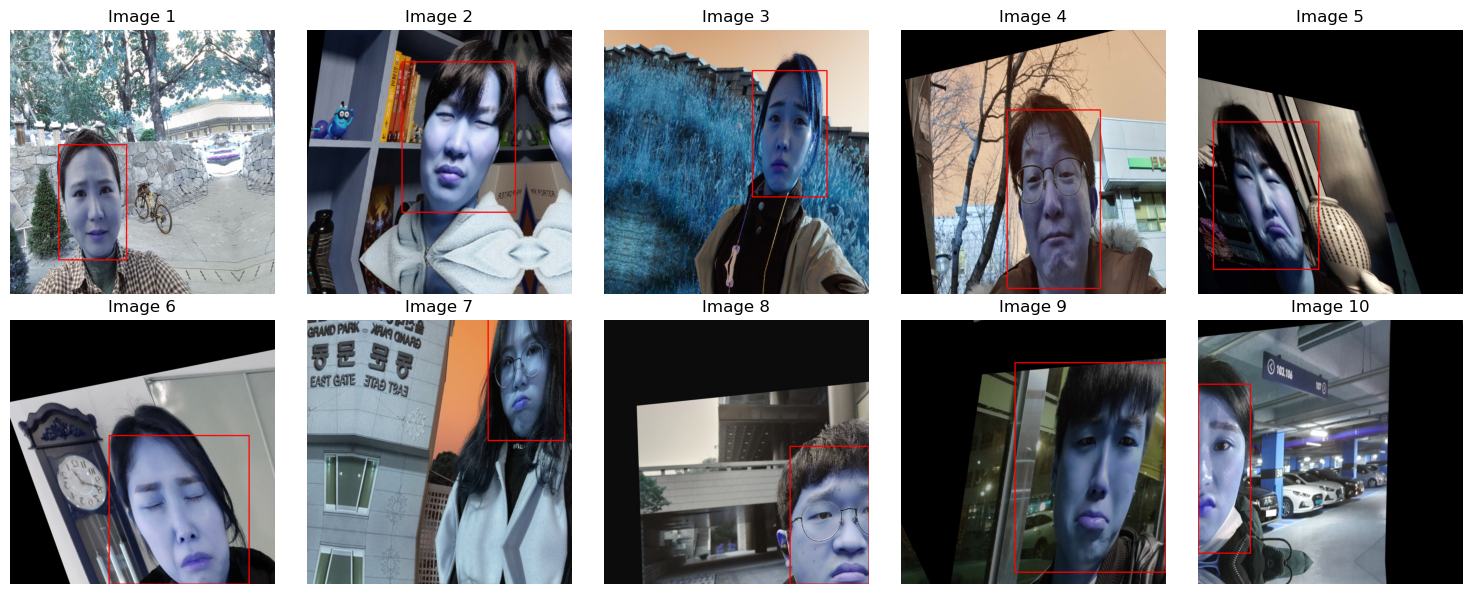

In [10]:
# 이미지와 바운딩 박스 시각화 (증강 데이터)
image_paths = []
boxes = []

for _, row in df_album.head(10).iterrows():
    img_file = row['filename']
    image_path = os.path.join(output_dir, img_file)
    image_paths.append(image_path)

    box_info = {
        'minX': int(row['minX']),
        'minY': int(row['minY']),
        'maxX': int(row['maxX']),
        'maxY': int(row['maxY']),
    }
    boxes.append(box_info)

# 시각화
visualize_images_with_boxes(image_paths, boxes)

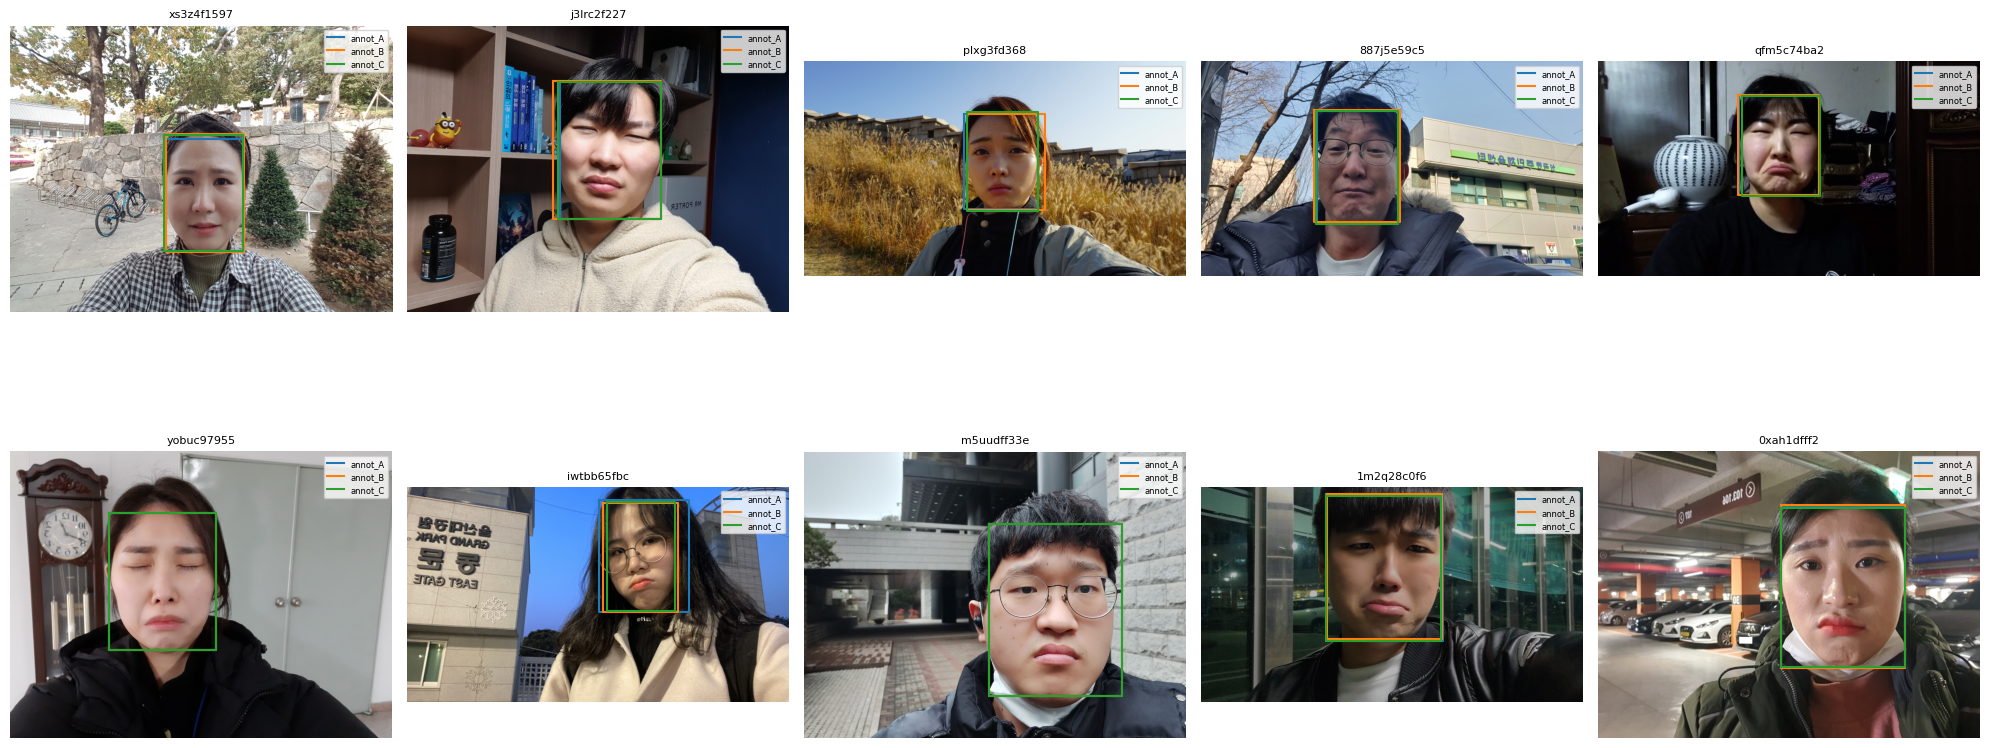

In [11]:
# 이미지와 바운딩 박스 시각화 (원본 데이터)

visualize_boxes(df, img_dir)